### Bollinger Bands Backtest

In [1]:
import pandas as pd
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
#%matplotlib widget

#This is the URL of the file

#1min data
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339325&authkey=!AHOCBUokDjDiCc8"

#1 second data
#url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339754&authkey=!ACcJZZPFqOmKVUY"

eurgbp1m_data = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column
close = eurgbp1m_data["close"].to_numpy() #We transform the close prices into a numpy array
eurgbp1m_data.tail()

,open,high,low,close,volume
timestamp,,,,,
2024-08-21 23:55:00,0.85204,0.85210,0.85204,0.85209,35.610001
2024-08-21 23:56:00,0.85209,0.85210,0.85204,0.85205,30.100000
2024-08-21 23:57:00,0.85205,0.85205,0.85203,0.85203,13.250000
2024-08-21 23:58:00,0.85203,0.85208,0.85200,0.85207,25.340000
2024-08-21 23:59:00,0.85206,0.85206,0.85199,0.85200,11.280000


In [2]:
#Create a backtesting function that backtests based on Bollinger Bands
@njit(fastmath=True) #We use the njit decorator to compile the function to machine code, which makes it faster
def backtest_bollinger_bands(data, window, num_std_devs, fees_percentage=0.015, starting_cash=10000):
    
    
    #-------------------Bollinger Bands-------------------

    #We calculate the rolling mean:
    middle_band = np.zeros(len(data)) #We create an array of zeros to store the rolling mean
    for i in range(window, len(data)):
        middle_band[i] = np.mean(data[i-window:i]) #We calculate the rolling mean for each day

    #We calculate the rolling standard deviation:
    rolling_std = np.zeros(len(data))
    for i in range(window, len(data)):
        rolling_std[i] = np.std(data[i-window:i]) #We calculate the rolling standard deviation for each day

    #We calculate the upper and lower bands:
    upper_band = middle_band + num_std_devs * rolling_std
    lower_band = middle_band - num_std_devs * rolling_std


    

    #Strategy's logic:
    positions = np.zeros(len(data)) #We create an array of zeros to store the positions
    
    for i in range(window, len(data)): #from the second row to the last row of the data
        if data[i] < lower_band[i] and positions[i-1] == 0:
            positions[i] = 1 #long if the price is below the lower band and we don't have a position
        elif data[i] > upper_band[i] and positions[i-1] == 0:
            positions[i] = -1 #short if the price is above the upper band and we don't have a position
        elif data[i] > middle_band[i] and positions[i-1] == 1:
            positions[i] = 0 #close long position if the price is above the middle band and we have a long position
        elif data[i] < middle_band[i] and positions[i-1] == -1:
            positions[i] = 0 #close short position if the price is below the middle band and we have a short position
        else:
            positions[i] = positions[i-1] #carry on with the previous position if none of the conditions are met;

    #We calculate the returns of the strategy:
    
    market_returns = np.zeros(len(data)) #We create an array of zeros to store the market returns
    for i in range(1, len(data)):
        market_returns[i] = (data[i] - data[i-1]) / data[i-1] #We calculate the market returns for each day
    
    strategy_returns = np.zeros(len(data)) #We create an array of zeros to store the strategy returns
    for i in range(1, len(data)):
        strategy_returns[i] = positions[i-1] * market_returns[i] #We calculate the strategy returns for each day, shifting the positions array by 1 day
    

    #Calculate equity with for loop
    equity = np.zeros(len(data))
    equity[0] = starting_cash

    for i in range(1, len(data)):
        if positions[i-1] == positions[i]:
            equity[i] = equity[i-1] * (1 + strategy_returns[i])
        else:
            equity[i] = equity[i-1] * (1 + strategy_returns[i]) - equity[i-1] * fees_percentage / 100


    return equity

Numba execution time: 0.01634526252746582


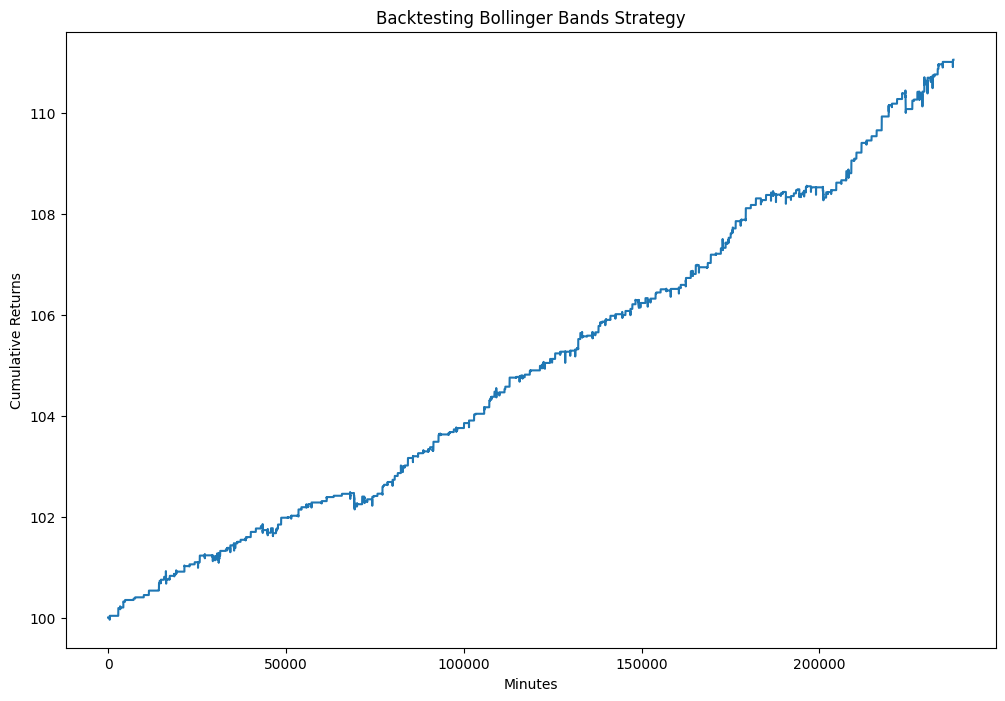

In [4]:
from time import time


numba_start_time = time()
v2 = backtest_bollinger_bands(data = close, window=60, num_std_devs=5, starting_cash=100, fees_percentage=0) #initialize the function with the close prices, the window and the number of standard deviations
numba_end_time = time()
print("Numba execution time:", numba_end_time - numba_start_time)
plt.figure(figsize=(12, 8))
plt.plot(v2)
plt.title("Backtesting Bollinger Bands Strategy")
plt.xlabel("Minutes")
plt.ylabel("Cumulative Returns")
plt.show()

#### Plotting the BBs and closing price:

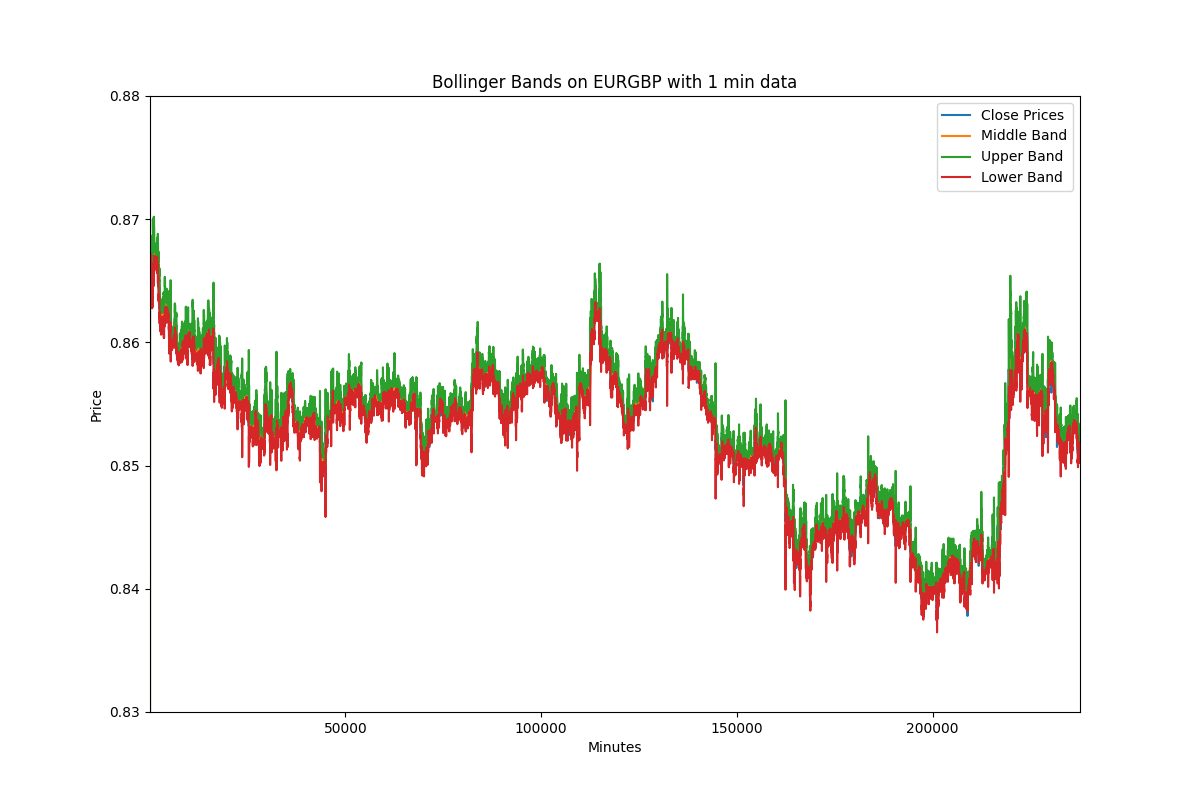

In [ ]:
#make a function that plots the bollinger bands

import matplotlib.pyplot as plt
%matplotlib widget
close = eurgbp1m_data["close"].to_numpy() #We transform the close prices into a numpy array



def plot_bollinger_bands(data, window, num_std_devs):

    #We calculate the rolling mean:
    middle_band = np.zeros(len(data)) #We create an array of zeros to store the rolling mean
    for i in range(window, len(data)):
        middle_band[i] = np.mean(data[i-window:i]) #We calculate the rolling mean for each day

    #We calculate the rolling standard deviation:
    rolling_std = np.zeros(len(data))
    for i in range(window, len(data)):
        rolling_std[i] = np.std(data[i-window:i]) #We calculate the rolling standard deviation for each day

    #We calculate the upper and lower bands:
    upper_band = middle_band + num_std_devs * rolling_std
    lower_band = middle_band - num_std_devs * rolling_std

    #plotting
    plt.figure(figsize=(12,8))
    plt.plot(data, label="Close Prices")
    plt.plot(middle_band, label="Middle Band")
    plt.plot(upper_band, label="Upper Band")
    plt.plot(lower_band, label="Lower Band")
    plt.title("Bollinger Bands on EURGBP with 1 min data")
    plt.ylabel("Price")
    plt.xlabel("Minutes")
    plt.xlim(window, len(data))
    plt.ylim(0.83, 0.88)
    plt.legend()
    plt.show()



plot_bollinger_bands(close, 60, 5) #We plot the Bollinger Bands with a window of 60 and 1 standard deviation